# A Hydrologic Neural Network from Scratch

In this notebook, I build a simple neural network to predict whether snow is observed on the ground Snotel at a site based on: (1) the day of year and (2) the mean air temperature for the day. This notebook is meant as a learning resource to understand how a neural network is built, trained, and tested. This is decidedly __not__ the way one would create a neural network for a more complicated problem, but is instead designed to provide a simple example to take a future machine learning afficionado "under the hood" of one of the most common machine learning approaches.

The neural net tries to predict a binary variable (snow on ground is either `True` or `False`) using predictor variables that are readily observed. We presume that the combination of day of year and mean air temperature are likely good predictors on whether or not snow is present. Day of year provides implicit information about season and is likely correlated with the presence/absence of snow (i.e., if I told you it was January 15 at a Snotel site, would you think snow is likely present? What about July 15?). Mean air temperature provides some information about the energy in the atmosphere and likely exhibits some correlation with the presence/absence of snow (i.e., if it is 26°C is it likely that snow is present? What about -15 °C?).

Note that this notebook very closely follows a nice example outlined in [this Medium article](https://towardsdatascience.com/machine-learning-for-beginners-an-introduction-to-neural-networks-d49f22d238f9) but uses real data from a Snotel site in an effort to make the problem more closely related to the hydrologic sciences. 

The network contains 2 input layers ('Day of Year' and 'Daily Mean Air Temperature'), 2 hidden layers (`h1` and `h2`), and a single output layer (`o1`, whether there is snow or not). Note that we're using the logistic sigmoid function as our activation function. So, the output of the neural network is a variable that is continuous on the interval (0,1). We turn this into a categorical variable by reclassifying output values between (0,5) as being _snow free_ and output values from [0.5,1.0) as being _snow covered_. The visualization of our neural network is as follows:



Now, follow along as we build the neural network.

### 1. Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

snotel_fname = 'snotel_978_bogus_basin_clean.txt'

### 2. Read in the Data

Make sure to set the index of the dataframe to the `Date` variable and drop any data rows with `nan`s. Show the head of the dataframe.

In [2]:
df = pd.read_csv(snotel_fname)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.dropna()
df.head()

,Snow Water Equivalent [mm],Accumulated Precipitation [mm],Precipitation Increment [mm],Tmax (degC),Tmin (degC),Tmean (degC),Year,DOY,Snow on Ground
Date,,,,,,,,,
1999-10-01,0.0,0.0,0.0,11.722,2.889,7.500,1999,274,0
1999-10-02,0.0,0.0,0.0,11.611,0.500,6.278,1999,275,0
1999-10-03,0.0,0.0,0.0,14.389,0.500,7.778,1999,276,0
1999-10-04,0.0,0.0,0.0,19.722,6.778,13.500,1999,277,0
1999-10-05,0.0,0.0,0.0,16.889,8.111,12.389,1999,278,0


### 3. Define the Neural Network Properties

We need to define the following:
* Our activation function: $f(x) = \frac{1}{(1 + \exp{-x})}$
* The derivative of the activation function: ${f}^{\prime}(x) = f(x)(1 - f(x))$
* The loss function, which we will take as the mean squared error: $\frac{1}{N}\sum_{i=1}^{N}(y_{obs} - y_{pred})^2$

In [3]:
def sigmoid(x):
    # Our activation function: f(x) = 1 / (1 + e^(-x))
    return 1 / (1 + np.exp(-x))

def deriv_sigmoid(x):
    # Derivative of sigmoid: f'(x) = f(x)*(1 - f(x))
    fx = sigmoid(x)
    return fx*(1 - fx)

def mse_loss(y_true, y_pred):
    # y_true and y_pred are numpy arrays of the same length
    return ((y_true - y_pred)**2).mean()



Now we will create a new class for our neural network. This class will contain: (1) a constructor function (which initializes the weights and biases for the hidden and output layers), (2) a feed forward function to produce an output layer based on weights, biases, and inputs, and (3) a training function to compute the weights and biases of the hidden and output layers given inputs and the observed outputs (i.e., the true "snow on ground" condition) using a stochastic gradient descent algorithm.

The output of a "trained" network are weights and bias values for the hidden and output layers of the network after training the network for a set number of epochs. Also output from the training function is the loss rate as a function of the epoch number. 

In [ ]:
class OurNeuralNetwork:
    '''
    A neural network with:
        - 2 inputs
        - a hidden layer with 2 neurons (h1, h2)
        - an output layer with 1 neuron (o1)
    '''
    def __init__(self):
        # Weights
        self.w1 = np.random.normal()
        self.w2 = np.random.normal()
        self.w3 = np.random.normal()
        self.w4 = np.random.normal() 
        self.w5 = np.random.normal()
        self.w6 = np.random.normal()
        
        # Biases
        self.b1 = np.random.normal()
        self.b2 = np.random.normal()
        self.b3 = np.random.normal()
    
    def feedforward(self, x):
        # x is a numpy array with 2 elements
        h1 = sigmoid(self.w1*x[0] + self.w2*x[1] + self.b1)
        h2 = sigmoid(self.w3*x[0] + self.w4*x[1] + self.b2)
        o1 = sigmoid(self.w5*h1 + self.w6*h2 + self.b3)
        return o1
    
    def train(self, data, all_y_trues):
        '''
        - data is a (n x 2) numpy array, n = # of samples in the dataset.
        - all_y_trues is a (n x 1) numpy array. Elements in all_y_trues correspond
          to those in data
        '''
        learn_rate = 0.1
        epochs = 1000 # number of times to loop through the entire dataset
        
        loss_calc = np.nan*np.ones((epochs,1))
        
        for epoch in range(epochs):
            for x, y_true in zip(data, all_y_trues):
                
                # --- Do a feedforward (we'll need these values later)
                sum_h1 = self.w1*x[0] + self.w2*x[1] + self.b1
                h1 = sigmoid(sum_h1)
                
                sum_h2 = self.w3*x[0] + self.w4*x[1] + self.b2
                h2 = sigmoid(sum_h2)
                
                sum_o1 = self.w5*h1 + self.w6*h2 + self.b3
                o1 = sigmoid(sum_o1)
                y_pred = o1
                
                # --- Calculate partial derivatives
                # --- Naming: d_L_d_w1 represents 'partial L / partial w1'
                d_L_d_ypred = -2.0*(y_true - y_pred)
                
                # Neuron o1
                d_ypred_d_w5 = h1*deriv_sigmoid(sum_o1)
                d_ypred_d_w6 = h2*deriv_sigmoid(sum_o1)
                d_ypred_d_b3 = deriv_sigmoid(sum_o1)
                
                d_ypred_d_h1 = self.w5*deriv_sigmoid(sum_o1)
                d_ypred_d_h2 = self.w6*deriv_sigmoid(sum_o1)
                
                # Neuron h1
                d_h1_d_w1 = x[0]*deriv_sigmoid(sum_h1)
                d_h1_d_w2 = x[1]*deriv_sigmoid(sum_h1)
                d_h1_d_b1 = deriv_sigmoid(sum_h1)
                
                # Neuron h2
                d_h2_d_w3 = x[0]*deriv_sigmoid(sum_h2)
                d_h2_d_w4 = x[1]*deriv_sigmoid(sum_h2)
                d_h2_d_b2 = deriv_sigmoid(sum_h2)
                
                # --- Update weights and biases
                # Neuron h1
                self.w1 -= learn_rate*d_L_d_ypred*d_ypred_d_h1*d_h1_d_w1
                self.w2 -= learn_rate*d_L_d_ypred*d_ypred_d_h1*d_h1_d_w2
                self.b1 -= learn_rate*d_L_d_ypred*d_ypred_d_h1*d_h1_d_b1

                # Neuron h2
                self.w3 -= learn_rate*d_L_d_ypred*d_ypred_d_h2*d_h2_d_w3
                self.w4 -= learn_rate*d_L_d_ypred*d_ypred_d_h2*d_h2_d_w4
                self.b2 -= learn_rate*d_L_d_ypred*d_ypred_d_h2*d_h2_d_b2

                # Neuron o1
                self.w5 -= learn_rate*d_L_d_ypred*d_ypred_d_w5
                self.w6 -= learn_rate*d_L_d_ypred*d_ypred_d_w6
                self.b3 -= learn_rate*d_L_d_ypred*d_ypred_d_b3 
            
            # -- Calculate total loss at the end of each epoch
            y_preds = np.apply_along_axis(self.feedforward, 1, data)
            #y_preds = np.where(y_preds>=0.5,1,0)
            loss = mse_loss(all_y_trues, y_preds)
            
            loss_calc[epoch] = loss
                
            if epoch % 10 == 0:
                print("Epoch %d loss: %.3f" % (epoch, loss)) 
                
        return loss_calc
                
                

### 3. Set Up the Data

In the cell below, we will select only the variables we need to feed to the neural net. We will divide up the the dataset into a training and testing period. The training data goes from 10/01/1999 until 09/30/2018 (20 water years). The testing period goes from 10/01/2018 until 09/30/2023 (5 water years). 

We create a `numpy` array of the inputs for the training period and the correct observations. We do the same for the test period.  

In [4]:
data_train = df[:'2018-09-30'][['Tmean (degC)','DOY']].to_numpy()
data_train[:,0] = (data_train[:,0] - np.mean(data_train[:,0])) / np.std(data_train[:,0])
data_train[:,1] = (data_train[:,1] - np.mean(data_train[:,1])) / np.std(data_train[:,1])
data_train.shape

obs_train = df[:'2018-09-30']['Snow on Ground'].to_numpy().astype('float')
obs_train.shape

data_test = df['2018-10-01':][['Tmean (degC)','DOY']].to_numpy()
data_test[:,0] = (data_test[:,0] - np.mean(data_test[:,0])) / np.std(data_test[:,0])
data_test[:,1] = (data_test[:,1] - np.mean(data_test[:,1])) / np.std(data_test[:,1])
data_test.shape

obs_test = df['2018-10-01':]['Snow on Ground'].to_numpy().astype('float')
obs_test.shape


array([[0.16627537, 0.86244526],
       [0.01440842, 0.87192325],
       [0.20082448, 0.88140125],
       ...,
       [0.76007264, 0.83401129],
       [0.8152518 , 0.84348928],
       [0.25600363, 0.85296727]])

### 4. Initialize and Train the Network

The network is initialized and trained based on the input data for the training period. Every 10 epochs, the training algorithm prints out the associated loss rate.

In [8]:
network = OurNeuralNetwork()
my_loss = network.train(data_train, obs_train)

Epoch 0 loss: 0.084
Epoch 10 loss: 0.040
Epoch 20 loss: 0.040
Epoch 30 loss: 0.040
Epoch 40 loss: 0.040
Epoch 50 loss: 0.040
Epoch 60 loss: 0.040
Epoch 70 loss: 0.040
Epoch 80 loss: 0.040
Epoch 90 loss: 0.040
Epoch 100 loss: 0.040
Epoch 110 loss: 0.040
Epoch 120 loss: 0.040
Epoch 130 loss: 0.040
Epoch 140 loss: 0.040
Epoch 150 loss: 0.040
Epoch 160 loss: 0.040
Epoch 170 loss: 0.040
Epoch 180 loss: 0.040
Epoch 190 loss: 0.040
Epoch 200 loss: 0.040
Epoch 210 loss: 0.040
Epoch 220 loss: 0.040
Epoch 230 loss: 0.040
Epoch 240 loss: 0.040
Epoch 250 loss: 0.040
Epoch 260 loss: 0.040
Epoch 270 loss: 0.040
Epoch 280 loss: 0.040
Epoch 290 loss: 0.040
Epoch 300 loss: 0.040
Epoch 310 loss: 0.040
Epoch 320 loss: 0.040
Epoch 330 loss: 0.040
Epoch 340 loss: 0.040
Epoch 350 loss: 0.040
Epoch 360 loss: 0.040
Epoch 370 loss: 0.040
Epoch 380 loss: 0.040
Epoch 390 loss: 0.040
Epoch 400 loss: 0.040
Epoch 410 loss: 0.040
Epoch 420 loss: 0.040
Epoch 430 loss: 0.040
Epoch 440 loss: 0.040
Epoch 450 loss: 0.040

### 5. Evaluate the Performancei

Plot the loss rate as a function of the training epoch. Note that we expect the loss rate to decrease to some asymptotic value over the course of the training process.

Text(0, 0.5, 'Loss Rate')

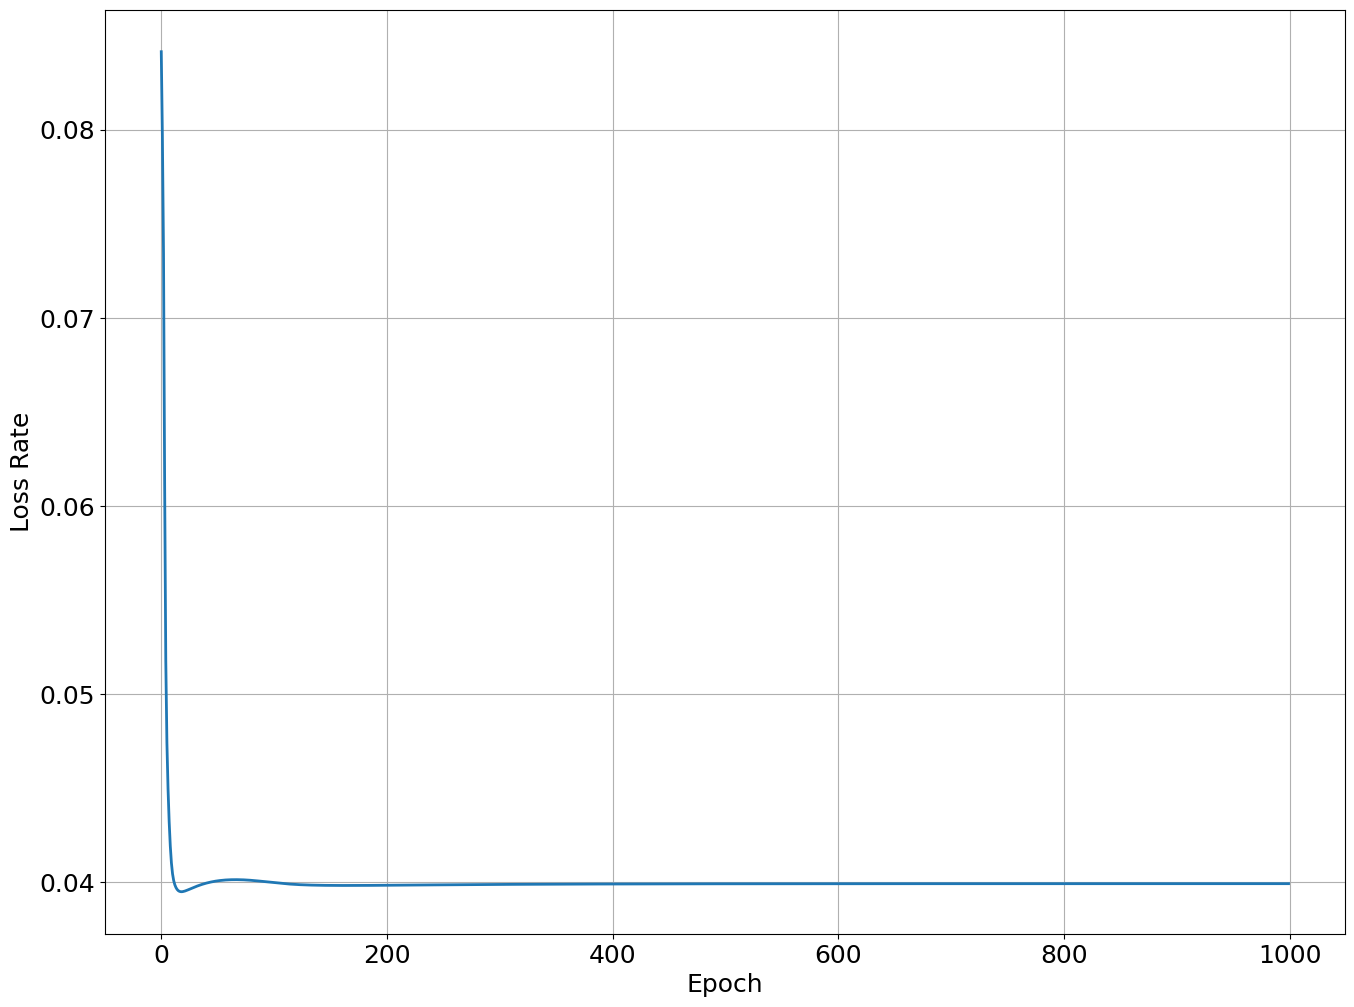

In [9]:
plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size':18})
plt.plot(my_loss,linewidth=2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.show()

Now use the trained neural network to make predictions for the test data using the `feedforward` function from the network. __NOTE__: the neural network has not seen the data from from the test period. So this is a true `out-of-sample` test of our fit network. Note that we could have done something more sophisticated like further subdividing the training period into train and validate samples and then randomly swapping, but for now we avoid that complication. 

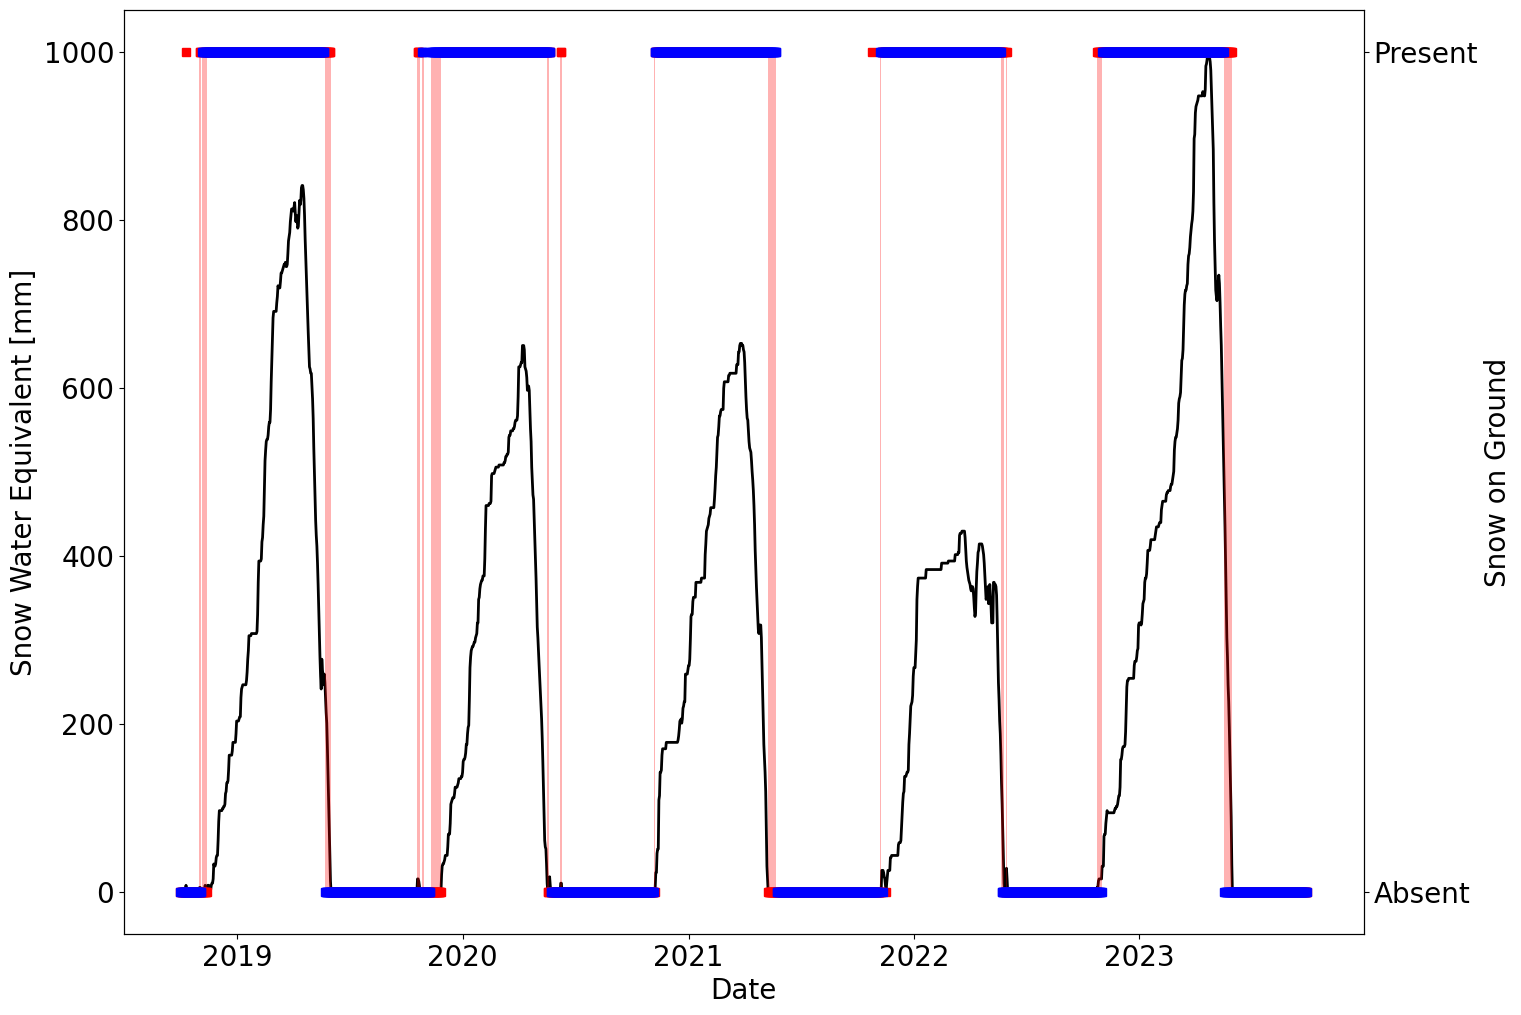

In [27]:
# Generate predictions of the presence of snow on the ground based on input from 
# the test period
y_preds_test = np.apply_along_axis(network.feedforward,1,data_test)

# Classify the predictions into a binary prediction. 1 = snow present, 0 = snow absent
sog_preds_test = np.where(y_preds_test>=0.5,1,0)

# Get the true values of snow presence during the test period
sog_true_test = df['2018-10-01':]['Snow on Ground'].to_numpy()

# Compute an array we can use to identify where the neural network predictions and
# observations disagree. Subtract the array containing the true condition from 
# the predicted one. Where they agree the value will be 0. Where the value is 
# different from 0, there was either a false negative or false positive condition
sog_disagree = np.where((sog_preds_test - sog_true_test)!=0,1,0)

# Create a 2-axis plot showing snow water equivalent on top of predicted and observed
# values of snow presence/absence. Highlight the times when the neural net and 
# observations do not agree
fig, ax1 = plt.subplots(figsize=(16,12))
plt.rcParams.update({'font.size':20})

ax2 = ax1.twinx()
ax2.plot(df['2018-10-01':].index,sog_true_test,'rs')
ax2.plot(df['2018-10-01':].index,sog_preds_test,'bs')
ax2.bar(df['2018-10-01':].index,sog_disagree,width=1.0,facecolor='red',alpha=0.3)
ax2.set_ylim([-0.05,1.05])
ax2.set_ylabel('Snow on Ground')
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Absent','Present'])

ax1.plot(df['2018-10-01':].index,df['2018-10-01':]['Snow Water Equivalent [mm]'],'k-',linewidth=2)
ax1.set_ylim([-50.0,1050.0])
ax1.set_ylabel('Snow Water Equivalent [mm]')
ax1.set_xlabel('Date')
plt.show()

Now show comparisons using something called a confusion matrix or contingency table. This is a method of showing the number of true positives (predicted and observed snow presence), true negatives (predicted and observed snow absence), false positives (predicted unobserved snow presence), and false negatives (did not predict observed snow presence). 

__NOTE__: Other Python machine learning libraries have built-in capabilities to plot the confusion matrix. We will not use those here, but will build a simple one from scratch. 

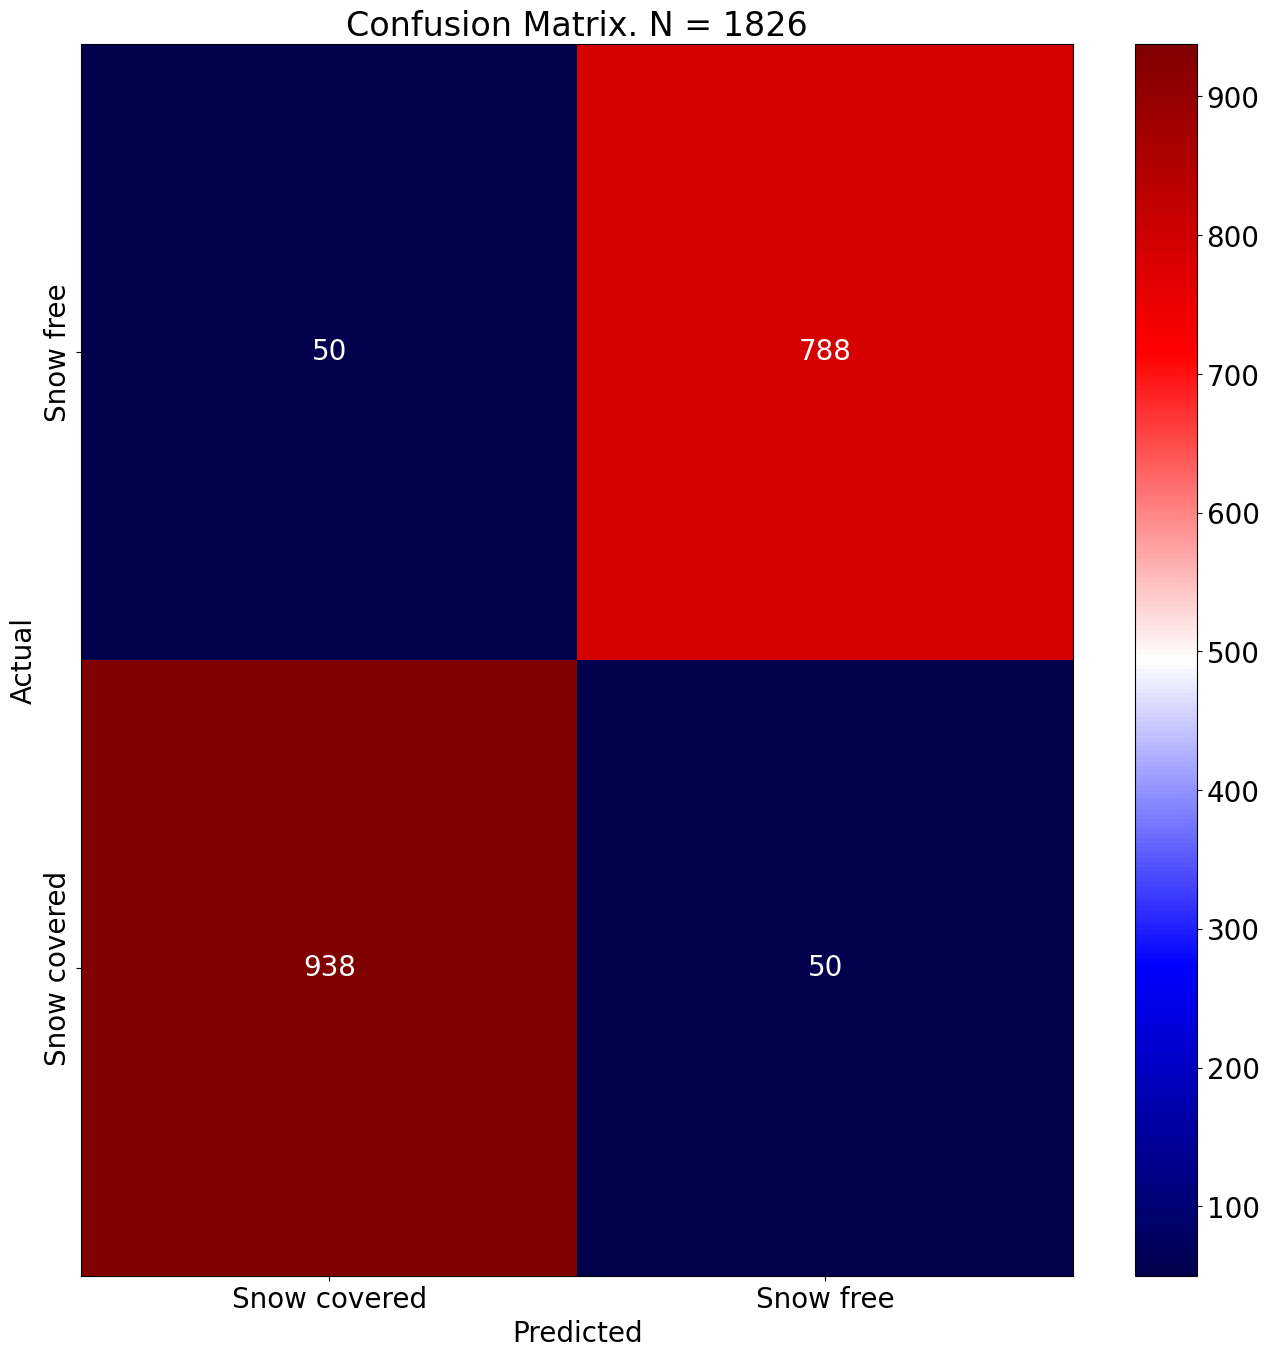

In [12]:
# Comput elements of the confusion matrix
nTruePos = np.sum(np.where((sog_preds_test==1)&(sog_true_test==1),1,0))
nTrueNeg = np.sum(np.where((sog_preds_test==0)&(sog_true_test==0),1,0))
nFalsePos = np.sum(np.where((sog_preds_test==1)&(sog_true_test==0),1,0)) 
nFalseNeg = np.sum(np.where((sog_preds_test==0)&(sog_true_test==1),1,0)) 

# Optional to convert these numbers into rates (e.g., true hit rate, true miss rate, etc.)
ConfusionMat = np.zeros((2,2))
ConfusionMat[0,0] = nTruePos #/ np.sum((sog_true==1))
ConfusionMat[0,1] = nFalseNeg #/ np.sum((sog_true==1))
ConfusionMat[1,0] = nFalsePos #/ np.sum((sog_true==0))
ConfusionMat[1,1] = nTrueNeg #/ np.sum((sog_true==0))

# Create the plot
fig = plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size':20})
plt.pcolormesh(ConfusionMat,cmap='seismic')
plt.title('Confusion Matrix. N = '+str(sog_true_test.size))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(ticks=[0.5,1.5], labels=['Snow covered','Snow free'])
plt.yticks(ticks=[0.5,1.5], labels=['Snow covered','Snow free'],rotation=90,va='center')
plt.text(0.5,0.5,'{:.0f}'.format(ConfusionMat[0,0]),ha='center',va='center',size=20,color='w')
plt.text(1.5,0.5,'{:.0f}'.format(ConfusionMat[1,0]),ha='center',va='center',size=20,color='w')
plt.text(0.5,1.5,'{:.0f}'.format(ConfusionMat[0,1]),ha='center',va='center',size=20,color='w')
plt.text(1.5,1.5,'{:.0f}'.format(ConfusionMat[1,1]),ha='center',va='center',size=20,color='w')
plt.colorbar()
plt.show()